## 1) Imports & Setup

In [1]:
import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.metrics import (
    roc_auc_score, roc_curve, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, accuracy_score
)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb  # callbacks for early stopping
import joblib

print("Libraries imported.")

Libraries imported.


## 2) Load Data

In [2]:
DATA_PATH = "GearBoost Prepared Data.xlsx"
if not os.path.exists(DATA_PATH):
    alt =r"C:\Users\Fatmanur\Desktop\GearBoost Prepared Data.xlsx"
    if os.path.exists(alt):
        DATA_PATH = alt

print("Using data path:", DATA_PATH)
df = pd.read_excel(DATA_PATH)

TARGET = "Broken"
assert TARGET in df.columns, f"Missing target column '{TARGET}'"

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# Use only numeric features
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
X = X[num_cols].copy()

print("Shape -> X:", X.shape, " y:", y.shape)
print("Numeric feature count:", len(num_cols))

# Class ratio for scale_pos_weight
pos = int(y.sum())
neg = len(y) - pos
spw = (neg / pos) if pos > 0 else 1.0
print(f"Class ratio (neg/pos) ~ {spw:.2f}")

Using data path: GearBoost Prepared Data.xlsx
Shape -> X: (55185, 198)  y: (55185,)
Numeric feature count: 198
Class ratio (neg/pos) ~ 6.13


## 3) Define Models & Pipeline

In [3]:
# === 3) Define Models & Pipeline (LightGBM + XGBoost + CatBoost) ===
# CatBoost yüklü değilse: pip install catboost
RUN_CATBOOST = True  # CatBoost'u dahil etmek için True

# XGBoost ve LightGBM zaten import edildi varsayıyorum:
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# import lightgbm as lgb

# Sınıf oranı: spw değişkeni yukarıda hesaplanmış olmalı
# spw = (neg / pos) if pos > 0 else 1.0

models = {
    "LightGBM": LGBMClassifier(
        n_estimators=300,
        learning_rate=0.08,
        num_leaves=63,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        class_weight="balanced",
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.08,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",   # AUC istersen "auc" yap
        tree_method="hist",
        n_jobs=-1,
        scale_pos_weight=spw,
        random_state=42
    ),
}

# CatBoost'u güvenli şekilde ekle (yüklü değilse devre dışı bırak)
if RUN_CATBOOST:
    try:
        from catboost import CatBoostClassifier
        models["CatBoost"] = CatBoostClassifier(
            iterations=300,
            learning_rate=0.08,
            depth=6,
            loss_function="Logloss",       # AUC istersen "AUC"
            auto_class_weights="Balanced", # sınıf dengesizliği için
            random_state=42,
            verbose=False
            # GPU'n varsa: task_type="GPU", devices="0"
        )
    except ImportError:
        RUN_CATBOOST = False
        print("CatBoost paketi bulunamadı. Kurmak için: pip install catboost")

def make_pipe(model):
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", model)
    ])

print("Models ready:", list(models.keys()))


Models ready: ['LightGBM', 'XGBoost', 'CatBoost']


## 4) CV Setup (TimeSeriesSplit & scoring)

In [4]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": "f1",
    "precision": "precision",
    "recall": "recall"
}
print("CV and scoring ready.")

CV and scoring ready.


## 5) Cross-Validate Models (Quick Summary)

In [5]:
results = {}
for name, model in models.items():
    print(f"\n=== {name} (TimeSeriesSplit={n_splits}) ===")
    pipe = make_pipe(model)
    cv_res = cross_validate(
        pipe, X, y, cv=tscv, scoring=scoring,
        n_jobs=-1, return_train_score=False
    )
    results[name] = cv_res
    for key in scoring:
        vals = cv_res[f"test_{key}"]
        print(f"  {key:<9}: mean={vals.mean():.4f}  std={vals.std():.4f}")
    print("-"*50)

rows = []
for name, cv_res in results.items():
    row = {"model": name}
    for k in scoring.keys():
        vals = cv_res[f"test_{k}"]
        row[f"{k}_mean"] = float(vals.mean())
        row[f"{k}_std"]  = float(vals.std())
    rows.append(row)
summary_df = pd.DataFrame(rows).set_index("model").round(4)
summary_df



=== LightGBM (TimeSeriesSplit=5) ===
  roc_auc  : mean=0.9944  std=0.0042
  accuracy : mean=0.9792  std=0.0079
  f1       : mean=0.9229  std=0.0203
  precision: mean=0.9346  std=0.0084
  recall   : mean=0.9120  std=0.0349
--------------------------------------------------

=== XGBoost (TimeSeriesSplit=5) ===
  roc_auc  : mean=0.9906  std=0.0068
  accuracy : mean=0.9713  std=0.0100
  f1       : mean=0.8960  std=0.0221
  precision: mean=0.8911  std=0.0127
  recall   : mean=0.9026  std=0.0455
--------------------------------------------------

=== CatBoost (TimeSeriesSplit=5) ===
  roc_auc  : mean=0.9895  std=0.0074
  accuracy : mean=0.9672  std=0.0109
  f1       : mean=0.8862  std=0.0173
  precision: mean=0.8476  std=0.0142
  recall   : mean=0.9301  std=0.0417
--------------------------------------------------


,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std,f1_mean,f1_std,precision_mean,precision_std,recall_mean,recall_std
model,,,,,,,,,,
LightGBM,0.9944,0.0042,0.9792,0.0079,0.9229,0.0203,0.9346,0.0084,0.9120,0.0349
XGBoost,0.9906,0.0068,0.9713,0.0100,0.8960,0.0221,0.8911,0.0127,0.9026,0.0455
CatBoost,0.9895,0.0074,0.9672,0.0109,0.8862,0.0173,0.8476,0.0142,0.9301,0.0417


## 6) Manual OOF Predictions with Early Stopping

In [11]:
rows = []
for name, cv_res in results.items():
    row = {"model": name}
    for k in scoring.keys():
        vals = cv_res[f"test_{k}"]
        row[f"{k}_mean"] = float(vals.mean())
        row[f"{k}_std"]  = float(vals.std())
    rows.append(row)
summary_df = pd.DataFrame(rows).set_index("model")
print("\nCV Summary:\n", summary_df.round(4))

# --------------------------------------------------------
# 4) Yardımcı: XGBoost sürüm-uyumlu fit (early stopping)
# --------------------------------------------------------
def fit_xgb_with_es(pipe, X_tr, y_tr, X_val, y_val):
    """
    XGBoost için sürüme göre sırayla dener:
      1) callbacks (yeni sürümler)
      2) early_stopping_rounds (bazı sürümler)
      3) yedek: ES olmadan
    """
    # Önce sadece eval_set paramını ver
    base_kwargs = {"model__eval_set": [(X_val, y_val)]}

    # 1) callbacks dene
    try:
        from xgboost.callback import EarlyStopping as XgbEarlyStopping
        return pipe.fit(
            X_tr, y_tr,
            **base_kwargs,
            model__callbacks=[XgbEarlyStopping(rounds=50, save_best=True, maximize=False)]
        )
    except Exception:
        pass

    # 2) early_stopping_rounds dene
    try:
        return pipe.fit(
            X_tr, y_tr,
            **base_kwargs,
            model__early_stopping_rounds=50
        )
    except Exception:
        pass

    # 3) yedek: ES olmadan
    return pipe.fit(X_tr, y_tr)

# ---------------------------------------------------------
# 5) Manuel OOF + early stopping ile olasılıkları üret
# ---------------------------------------------------------
oof = {name: np.full(len(y), np.nan, dtype=float) for name in models}

for fold, (tr_idx, te_idx) in enumerate(tscv.split(X, y), 1):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    print(f"\nFold {fold}: train={len(tr_idx)}, test={len(te_idx)}")

    # train'in son %20'sini validation ayır (min 1000 örnek; erken foldlarda koruma)
    val_size = max(int(0.2 * len(tr_idx)), 1000)
    if val_size >= len(tr_idx):
        val_size = max(1, len(tr_idx)//5)
    X_tr_sub, X_val = X_tr.iloc[:-val_size], X_tr.iloc[-val_size:]
    y_tr_sub, y_val = y_tr.iloc[:-val_size], y_tr.iloc[-val_size:]

    for name, base_model in models.items():
        pipe = make_pipe(base_model)

        if name == "LightGBM":
            fit_params = {
                "model__eval_set": [(X_val, y_val)],
                "model__eval_metric": "auc",
                "model__callbacks": [lgb.early_stopping(stopping_rounds=50, verbose=False)],
            }
            pipe.fit(X_tr_sub, y_tr_sub, **fit_params)

        elif name == "XGBoost":
            fit_xgb_with_es(pipe, X_tr_sub, y_tr_sub, X_val, y_val)

        elif name == "CatBoost":
            fit_params = {
                "model__eval_set": [(X_val, y_val)],
                "model__early_stopping_rounds": 50,
                "model__use_best_model": True
            }
            pipe.fit(X_tr_sub, y_tr_sub, **fit_params)

        else:
            # Beklenmedik model adı: ES olmadan
            pipe.fit(X_tr_sub, y_tr_sub)

        proba = pipe.predict_proba(X_te)[:, 1]
        oof[name][te_idx] = proba


CV Summary:
           roc_auc_mean  roc_auc_std  accuracy_mean  accuracy_std  f1_mean  \
model                                                                       
LightGBM        0.9944       0.0042         0.9792        0.0079   0.9229   
XGBoost         0.9906       0.0068         0.9713        0.0100   0.8960   
CatBoost        0.9895       0.0074         0.9672        0.0109   0.8862   

          f1_std  precision_mean  precision_std  recall_mean  recall_std  
model                                                                     
LightGBM  0.0203          0.9346         0.0084       0.9120      0.0349  
XGBoost   0.0221          0.8911         0.0127       0.9026      0.0455  
CatBoost  0.0173          0.8476         0.0142       0.9301      0.0417  

Fold 1: train=9200, test=9197
[LightGBM] [Info] Number of positive: 1162, number of negative: 6198
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032903 seconds.
You can set `force_co

## 7) OOF ROC & Best Model

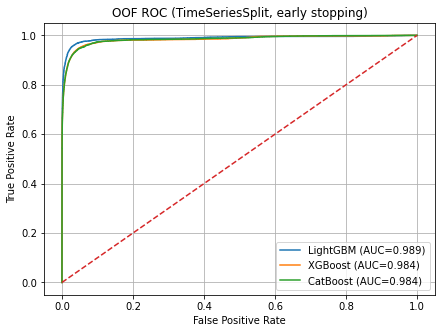

Best OOF AUC: LightGBM = 0.9888


In [12]:
plt.figure(figsize=(7,5))
best_model_name, best_auc = None, -1.0
for name, proba in oof.items():
    mask = ~np.isnan(proba)
    auc  = roc_auc_score(y[mask], proba[mask])
    fpr, tpr, _ = roc_curve(y[mask], proba[mask])
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    if auc > best_auc:
        best_auc, best_model_name = auc, name

plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("OOF ROC (TimeSeriesSplit, early stopping)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Best OOF AUC: {best_model_name} = {best_auc:.4f}")

## 8) Threshold Optimization (F1)

In [13]:
def best_threshold_by_f1(y_true, proba):
    ts = np.linspace(0.05, 0.95, 181)
    best_t, best_f1 = 0.5, -1.0
    for t in ts:
        pred = (proba >= t).astype(int)
        f1 = f1_score(y_true, pred, zero_division=0)
        if f1 > best_f1:
            best_f1, best_t = f1, t
    return best_t, best_f1

proba_best = oof[best_model_name]
mask = ~np.isnan(proba_best)
t_opt, f1_opt = best_threshold_by_f1(y[mask], proba_best[mask])
pred_opt = (proba_best[mask] >= t_opt).astype(int)

print(f"Optimal threshold (F1): {t_opt:.3f}  |  F1={f1_opt:.4f}")
print("Accuracy :", accuracy_score(y[mask], pred_opt))
print("Precision:", precision_score(y[mask], pred_opt, zero_division=0))
print("Recall   :", recall_score(y[mask], pred_opt, zero_division=0))
print("Confusion matrix:\n", confusion_matrix(y[mask], pred_opt))

Optimal threshold (F1): 0.435  |  F1=0.9146
Accuracy : 0.9769707513319561
Precision: 0.9182186234817814
Recall   : 0.9109897172236504
Confusion matrix:
 [[39256   505]
 [  554  5670]]


## 9) Final Train & Save Pipeline

In [14]:
val_size = max(int(0.1 * len(X)), 1000)
if val_size >= len(X):
    val_size = max(1, len(X)//10)

X_tr_all, X_val_all = X.iloc[:-val_size], X.iloc[-val_size:]
y_tr_all, y_val_all = y.iloc[:-val_size], y.iloc[-val_size:]

final_model = make_pipe(models[best_model_name])

final_fit_params = {}
if best_model_name == "LightGBM":
    final_fit_params = {
        "model__eval_set": [(X_val_all, y_val_all)],
        "model__eval_metric": "auc",
        "model__callbacks": [lgb.early_stopping(stopping_rounds=50, verbose=False)],
    }
elif best_model_name == "XGBoost":
    final_fit_params = {
        "model__eval_set": [(X_val_all, y_val_all)],
        "model__early_stopping_rounds": 50
    }
elif best_model_name == "CatBoost":
    final_fit_params = {
        "model__eval_set": [(X_val_all, y_val_all)],
        "model__early_stopping_rounds": 50,
        "model__use_best_model": True
    }

final_model.fit(X_tr_all, y_tr_all, **final_fit_params)
joblib.dump(final_model, "gearboost_best_pipeline.joblib")
print("Saved -> gearboost_best_pipeline.joblib")

[LightGBM] [Info] Number of positive: 6874, number of negative: 42793
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50489
[LightGBM] [Info] Number of data points in the train set: 49667, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Saved -> gearboost_best_pipeline.joblib


## 10) (Optional) Last Fold Report

In [15]:
last_fold = list(tscv.split(X, y))[-1]
tr_idx, te_idx = last_fold
X_tr_last, X_te_last = X.iloc[tr_idx], X.iloc[te_idx]
y_tr_last, y_te_last = y.iloc[tr_idx], y.iloc[te_idx]

# best model ile (tekrar) fit
if best_model_name == "LightGBM":
    final_model.fit(
        X_tr_last, y_tr_last,
        model__eval_set=[(X_val_all, y_val_all)],
        model__eval_metric="auc",
        model__callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
    )
elif best_model_name == "XGBoost":
    fit_xgb_with_es(final_model, X_tr_last, y_tr_last, X_val_all, y_val_all)
elif best_model_name == "CatBoost":
    final_model.fit(
        X_tr_last, y_tr_last,
        model__eval_set=[(X_val_all, y_val_all)],
        model__early_stopping_rounds=50,
        model__use_best_model=True
    )
else:
    final_model.fit(X_tr_last, y_tr_last)

y_pred_last = final_model.predict(X_te_last)
y_prob_last = final_model.predict_proba(X_te_last)[:, 1]
print("\n=== Last Fold Report (best model) ===")
print(classification_report(y_te_last, y_pred_last, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_te_last, y_pred_last))
print("ROC AUC (last fold):", roc_auc_score(y_te_last, y_prob_last))

[LightGBM] [Info] Number of positive: 6153, number of negative: 39835
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50489
[LightGBM] [Info] Number of data points in the train set: 45988, number of used features: 198
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

=== Last Fold Report (best model) ===
              precision    recall  f1-score   support

           0     0.9860    0.9900    0.9880      7615
           1     0.9510    0.9324    0.9416      1582

    accuracy                         0.9801      9197
   macro avg     0.9685    0.9612    0.9648      9197
weighted avg     0.9800    0.9801    0.9800      9197

Confusion Matrix:
 [[7539   76]
 [ 107 1475]]
ROC AUC (last fold): 0.9969231165118415
